In [1]:
import os
import json
from tqdm import tqdm
from tensorflow import keras
from IPython.display import clear_output
from collections import Counter
import time

import matplotlib.pyplot as plt
import numpy as np


from pathlib import Path

# Load input data

* data: Tabular data + ground truth
* dict_col_candidate_classes: a dictionary with filename_columns and in each of the an array of [(candidate_type, candidate_entity, original_cell_value, rank)]

# only consider candidate classes between columns that have links

In [2]:
# Load the dictionary with the lookup results for each cell value in the tabular data
def load_json(data_json):
    with open(data_json) as json_file:
        return json.load(json_file)

In [3]:
output_folder = "output\\"



data = load_json(output_folder+'data.json')
dict_col_candidate_classes = load_json(output_folder+'dict_col_candidate_classes.json')

# Assess lookup efficiency

In this step, provided that we have the ground truth, we asses if the expected class is in the top x of the retrieved candidate classes.

In [4]:
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper, JSON, N3
from pprint import pprint
import requests
import xml.etree.ElementTree as ET

In [5]:
def dbo_sparql_results(query_string):
    
    classes = list([])
    dbo_prefix = 'http://dbpedia.org/ontology/'
    
    
    sparql = SPARQLWrapper('https://dbpedia.org/sparql')
    sparql.setQuery(query_string)
    
    try:
        sparql.setReturnFormat(JSON)
        qres = sparql.query().convert()
        for entity_class in qres['results']['bindings']:
            if dbo_prefix in entity_class[list(qres['results']['bindings'][0].keys())[0]]['value']:
                candicate_class = entity_class[list(qres['results']['bindings'][0].keys())[0]]['value'].split(dbo_prefix)[1]
                classes.append(candicate_class)
    except:
        pass
    
    return classes

def get_dbo_subclass(superClass):
    
    query_string = f'''
    SELECT distinct ?subClass 
    WHERE {{ ?subClass rdfs:subClassOf dbo:{superClass}. }}
    '''
    return dbo_sparql_results(query_string)


def get_dbo_superclass(subclass):
    
    query_string = f'''
    SELECT distinct ?superClass 
    WHERE {{ dbo:{subclass} rdfs:subClassOf ?superClass . }}
    '''
    
    return dbo_sparql_results(query_string)


def get_dbo_superclasses(subclass):
    classes = list([])
    
    try:
        parent = get_dbo_superclass(subclass)
    except:
        return []
    
    while len(parent) > 0:
        classes.append(parent[0])
        parent = get_dbo_superclass(parent[0])
    return classes

In [6]:
def lookup_assessment_considering_hr(dict_cand, threshold = 10000):
    """
    This is a function that considers half a point (instead of a whole point) in case the predicted class is a parent of the expected type.
    """
    found = 0
    found_with = 0
    parent_found = 0
    total_columns = 0

    for file in dict_cand:
        for col in dict_cand[file]:
            candidate_class_without_hr = [x[0] for x in dict_cand[file][col]['class_without_hr'][:threshold]]
#             candidate_class_with_hr = dict_cand[file][col]['class_with_hr'][:threshold]
            actual_cls = data[file]['gt'][col]
            if actual_cls in candidate_class_without_hr:
                found+=1
                parent_found += 1
            # else we give half a point in case the predicted value is in the hierarchy (i.e. parent) of the actual value
            else:
                parents_of_expected_type = get_dbo_superclass(actual_cls)
                intersection = [value for value in parents_of_expected_type if value in candidate_class_without_hr]
                if len(intersection) > 0:
                    parent_found += 0.5
                    
#             if actual_cls in candidate_class_with_hr:
#                 found_with+=1
            total_columns+=1
    return (round(100*found/total_columns,2),round(100*parent_found/total_columns,2))

Next we implement the TF-IDF logic for scoring and sorting the types for the columns

In [7]:
import math
import pandas as pd

def lookup_vote_tfidf(dict_col_candidate_classes,threshold=1):
    
    dict_tfidf = dict()
    cls_terms = set()

    for file in dict_col_candidate_classes:
        for col in dict_col_candidate_classes[file]:
            key = 'file_%s_col_%s' % (file,col)
            temp = list()
            for cls in dict_col_candidate_classes[file][col]:
                if cls[3] <= threshold:
                    temp.append(cls[0])
            cls_terms = cls_terms | set(temp)
            dict_tfidf [key] = temp

    # Calculate Term Frequency
    dict_tf = dict()
    for t in cls_terms:
        dict_tf[t] = dict()
        for document in dict_tfidf:
            try: 
                dict_tf[t][document] = dict_tfidf[document].count(t) / len(dict_tfidf[document])
            except:
                dict_tf[t][document] = 0

    # Calculate Inverse Document Frequency
    dict_idf = dict()
    for t in cls_terms:
        count_document = 0
        for document in dict_tfidf:
            if dict_tfidf[document].count(t) > 0:
                count_document +=1
        dict_idf[t] = math.log(len(dict_tfidf)/(1+count_document))
        
    
    # Bring it all together to combine tf and idf
    dict_tf_idf_pred = dict()
    candidates_tfidf = list()

    for t in dict_tf:
        for d in dict_tf[t]:
            if abs(dict_tf[t][d]*dict_idf[t]) > 0:
                candidates_tfidf.append([d[5:d.find('_col_')], d[d.find('_col_')+5:],t,dict_tf[t][d],dict_idf[t],dict_tf[t][d]*dict_idf[t]])
                
    # Create a dataframe with the proposed candidates
    temp = pd.DataFrame(candidates_tfidf, columns=["filename","column","cls","tf","idf","tfidf"])
    
    #Sort the values to prep them for the assessment
    temp.sort_values(by=["filename", "column", "tfidf"], ascending=False, inplace=True)
    
    # and finally create the structure of the dictionary
    dict_candidate_with_tfidf = dict()
    for row in temp.iterrows():
        if row[1].filename not in dict_candidate_with_tfidf:
            dict_candidate_with_tfidf[row[1].filename] = dict()
        if row[1].column not in dict_candidate_with_tfidf[row[1].filename]:
            dict_candidate_with_tfidf[row[1].filename][row[1].column] = dict()
            dict_candidate_with_tfidf[row[1].filename][row[1].column]['class_without_hr'] = list()

        dict_candidate_with_tfidf[row[1].filename][row[1].column]['class_without_hr'].append((row[1].cls,row[1].tfidf))

    return dict_candidate_with_tfidf  

In [8]:
dict_candidate_with_tfidf = lookup_vote_tfidf(dict_col_candidate_classes,1)

with open(('output/type_prediction_tf_idf-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(dict_candidate_with_tfidf, fp)

1 (75.23, 78.9)
2 (81.65, 84.4)
3 (87.16, 88.53)
4 (87.16, 88.99)
5 (88.07, 90.37)
6 (88.99, 90.83)
7 (90.83, 92.2)
8 (91.74, 92.66)
9 (92.66, 93.12)
10 (93.58, 93.58)
11 (93.58, 93.58)
12 (93.58, 93.58)
13 (93.58, 93.58)
14 (93.58, 93.58)
15 (93.58, 93.58)


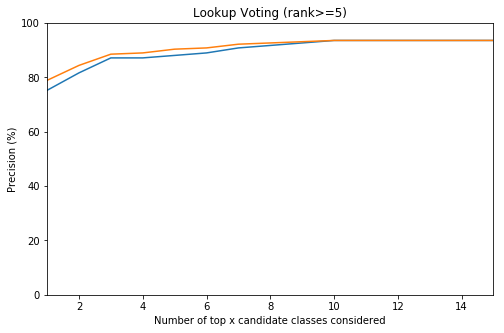

In [9]:
results = []
# dict_candidate_with_tfidf = lookup_vote_tfidf(dict_col_candidate_classes,1)

# then we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate_with_tfidf, i))
    print(x,y)
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.ylabel("Precision (%)")
plt.xlabel("Number of top x candidate classes considered")
plt.title("Lookup Voting (rank>=5)")
plt.axis(ymin=0, ymax=100, xmin=1, xmax=15)

plt.show()

In [ ]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")